<h1 align="center">Statistics for Machine Learning</h1>
<h2 align="center">Regression Trees</h2>

&nbsp;

### Overview

Decision trees can be used for both classification and regression. This notebook introduces regression trees using the CART implementation. The theory for building and applying decision trees for regression problems is detailed from scratch, with an overview of the binary tree data structure which has be used to create the model shown here. Issues with overfitting are also discussed using cost-complexity pruning, and other limitations are also described.

### Contents

Section 1 - Introduction to Decision Trees

Section 2 - Implementing a Regression Tree

Section 3 - Cost-Complexity Pruning

Section 4 - Generalising a Regression Tree to Higher Dimensions

Section 5 - Strengths and Limitations

Section 6 - Conclusion

Section 7 - Glossary

Section 8 - Further Reading

### Imports

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree

<h2 align="center">Section 1 - Introduction to Regression Trees</h2>

### 1.1 - Overview of Decision Trees

**Decision Trees** are supervised machine learning models that can be used to solve classification and regression problems. When applied to classification problems these trees are called **Classification Trees**, and when applied to regression problems they are called **Regression Trees**. This notebook focuses on Regression Trees - see the notebook *Classification Trees* for more about decision trees in classification tasks. Regression trees are **non-parametric** in that no assumptions are made about the form of the mapping function, and so the models are free to learn any functional form from the training data [1]. This means that tree-based models generally perform well regardless of the structure of the training data, unlike some other methods which assume Normally distributed data for example. There are some limitations however, which are discussed later in this notebook.

The training data is made up of inputs (features), and the corresponding outputs (targets). This notebook first assumes only a single feature variable is used, then later generalises to multi-dimensional input. The model recursively determines a locally optimum partition of the feature space, which attempts to separate different points from each other and group similar points together. That is, the data is split into two about some value, $s$: all data less than $s$ are grouped on the left, and all data greater than $s$ are grouped on the right. These partitions accumulate and divide the feature space into smaller and smaller regions, $R$, with only a few similar training points in each. When testing data is presented to the model, the new inputs are assessed against each of the splitting values to determine which region they belong to. The predicted output is then given as the mean of the target values for the training observations in that partition.

&nbsp;

### 1.2 - Model Structure

The structure of regression trees is tree-like (hence the name), consisting of *nodes* connected by *branches*. The first node is called the **root node**, which generally is depicted at the top of a diagram, with all subsequent branches descending from it. Each node has two branches, connecting to a left and right **child node** respectively. Given this terminology, nodes which connect to child nodes are called **parent nodes**. The nodes form if/else statements which collectively can make a prediction of the target value for a given input feature. In a regression tree, these nodes determine if the input feature is less than or equal to a splitting value. If it is, the decision node evaluates to True, and the input will navigate down the left branch of the node to be evaluated against the left child node. If it is not, the input will navigate down the right branch of the node to the right child node. The input will continue in this way until reaching a node which has no child nodes - such nodes are called **leaf nodes**, or **terminal nodes**. After training a model, all the data will be distributed across the tree in leaf nodes, with each node having a maximum number of observations. This is generally 5 observations [2], but can be changed depending on the application and is discussed later in this notebook. The output for a feature input arriving at a leaf node is predicted to be the arithmetic mean of the target values for the training observations in the leaf. It is possible to train a model without setting a maximum number of observations in a leaf node, creating a leaf for every value in the training data. This can lead to overfitting issues and poor performance on testing data.

A simple regression tree is shown below, purely to illustrate the tree-like nature of the model structure. This specific implementation of the method is from SciKit Learn, which, along with the theory about how this was generated, is covered later in this notebook.

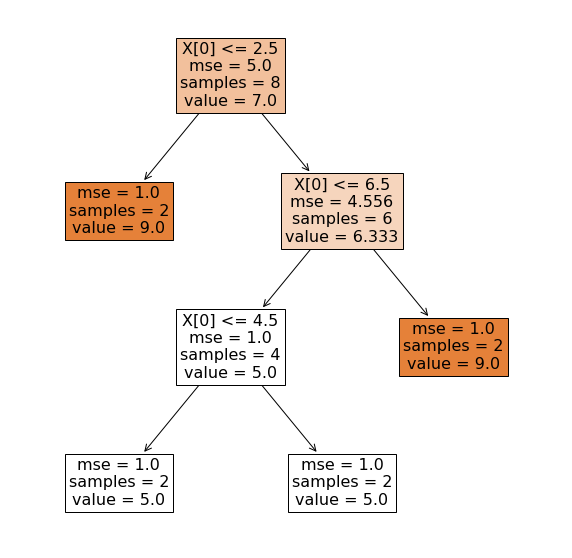

In [184]:
X = [[1],[2],[3],[4],[5],[6],[7],[8]]
y = [[10],[8],[6],[4],[4],[6],[8],[10]]

model = DecisionTreeRegressor(min_samples_leaf=2)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(10,10))
plot_tree(model, ax=ax, filled=True, fontsize=16)
print()

### 1.3 - Why use Simple Binary Splits?

It is possible to construct a model that uses multiway splits, that is, a model where each parent node is split into more than two child nodes. This may seem a good approach in principle, but there are a few issues with this in practice. First, these models divide the data too quickly, leaving insufficient data for the subsequent levels of the tree. Multiway splits can be achieved using a series of binary splits anyway, and so the simplest method is almost always preferred.

Each node splits the data about some value, $s$, into two branches where $x \leq s$ is assigned to the left child, and $x > s$ is assigned to the right child. This is the simplest method to partition the input space, but more complicated splits are also possible. These include linear combination splits, which split the data about $\sum a x \leq s $ and $\sum a x > s $ respectively. These conditions are also rarely used eventhough they may improve performance. The main reason for this is that linear combinations decrease the interpretability of the resulting tree, which is the primary factor for the use of decision trees in the first place for many industries such as medicine.


&nbsp;

### 1.4 - Classification and Regression Trees, CART

The method for producing a tree from training data is called **tree induction**, and there are several different implementations of this. The cell above described using a minimum number of observations (5) before a node could be split further - this is one example of a constraint in tree induction. Other constraints can be used to control: how to determine the splitting values, when to stop splitting, how to make predictions from observations in the leaf nodes, and so on [3]. This notebook will focus on the most popular method known as **Classification and Regression Trees** (CART), though other methods such as C4.5 are also used.

&nbsp;

### 1.5 - Partitioning the Feature Space

A decision tree must determine how to partition the training data such that the leaf nodes contain the most similar observations - this process is called **node splitting**. To do this, the values in the feature variable are first ordered. Next, the split-point is chosen by taking the midpoint between the feature value of first observation and the second observation (points 1 and 2). This divides the data in two: with the left side assigned to the left child node and the right side assigned to the right child node. Some criteria can then be used to assess how dissimilar the points are in each child node, then these measures can be added together to give an overall score for the split-point. Now the data can be recombined and split in the next location, which is determined by taking the midpoint of the next two consecutive points, that is, points 2 and 3 (note the overlap between 1 to 2, and 2 to 3). This process is repeated for each possible split-point, and the point corresponding to the lowest score (that is, the lowest dissimilarity in each child node) is chosen to partition the feature space. The result is a split which groups the most similar observations together. This process is repeated recursively until all the observations are assigned to leaf nodes. Note that since a locally optimum partition is chosen at each step, this method is **greedy**. Greedy approaches can be short-sighted, since a non-optimal split in one node may led to a very useful split in the following node - opportunities for such splits are discarded in a greedy approach. Additionally, given the same training data the model will always choose the same partitions, and so the method is also **deterministic**.

The graph below shows a number of split-points for some example data, which consists of 101 two-dimensional points with $x$ coordinates between -100 and 100. The data is taken from a toy dataset created by applying Gaussian noise to a quadratic function. The regression problem tackled in this notebook is predicting the $y$-coordinate of a point given its $x$-coordinate, using the data below to train a regression tree. The image on the left shows the first split-point, which is the midpoint of observations 1 and 2. The next plots show other split-points at 20% and 80% of the range of the feature space respectively.

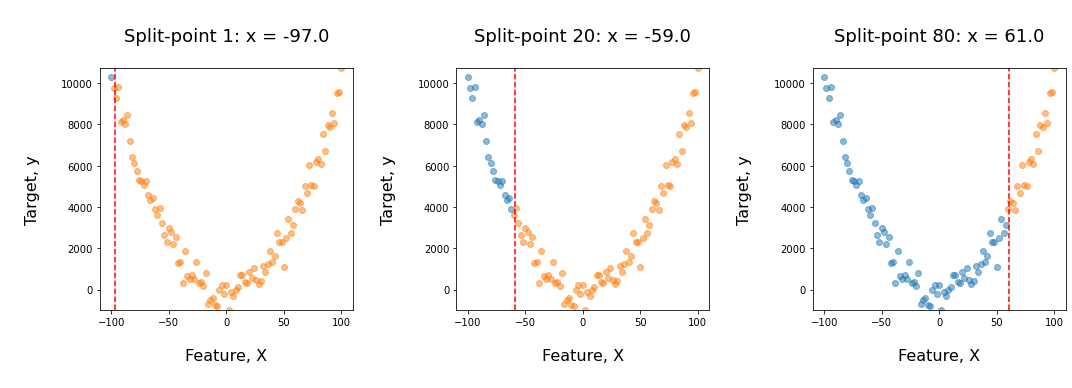

In [185]:
df = pd.read_csv('datasets/tree_data.csv')
X_train, y_train = df['X'], df['y']

fig, ax = plt.subplots(ncols=3, figsize=(15,5.5))

for i, split in enumerate([1,20,80]):
    split_loc = np.mean([X_train[split], X_train[split+1]])

    ax[i].set_title(f'\nSplit-point {split}: x = {split_loc}\n', fontsize=18)
    ax[i].set_xlabel('\nFeature, X\n', fontsize=16)
    ax[i].set_ylabel('\nTarget, y\n', fontsize=16)
    ax[i].set_ylim(min(y_train), max(y_train))

    ax[i].scatter(X_train[:split], y_train[:split], alpha=0.5)
    ax[i].scatter(X_train[split:], y_train[split:], alpha=0.5)
    ax[i].plot([split_loc, split_loc], [min(y_train), max(y_train)], c='red', linestyle='--')

fig.tight_layout()
# ax.set_title('\nRegression Problem Training Data\n', fontsize=22)

### 1.6 - Measure of Dissimilarity

The measure for how well a split separates observations in the feature space is an important hyperparameter. There are several metrics to choose from, including:

* Sum of Squared Residuals (SSR)
* Absolute Error
* Poisson Deviance
* Friedman Mean Squared Error

This notebook focuses on the Sum of Squared Residuals (SSR) method used in CART, which is analogous to finding the variance in each of the nodes. The features of a node $n$ can be partitioned at a split-point $s$, where features with values less than or equal to $s$ are assigned to the left child node and features with values greater than $s$ are assigned to the right node. Recall that $s$ is calculated by taking the midpoint each consecutive pair of training values in the feature space. The corresponding target values are also used in each child node. The difference between each target value and the average target value in the child node is called a residual. Squaring these and taking the sum gives the sum of the squared residuals. Note that dividing this quantity by the number of points gives the variance of the targets in the node. The graph below shows the residuals (dashed lines) for observations in the left child node and their mean (blue), and observations in the right child node and their mean (orange).

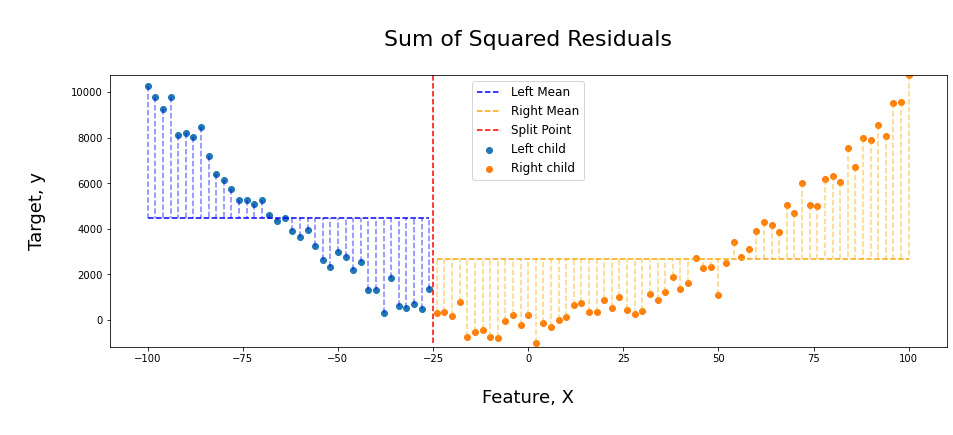

In [186]:
fig, ax = plt.subplots(figsize=(15,5))

pos = 38

ax.scatter(X_train[:pos], y_train[:pos], label='Left child')
ax.scatter(X_train[pos:], y_train[pos:], label='Right child')
ax.set_title('\nSum of Squared Residuals\n', fontsize=22)
ax.set_xlabel('\nFeature, X\n', fontsize=18)
ax.set_ylabel('\nTarget, y\n', fontsize=18)
ax.set_ylim(min(y_train)*1.2, max(y_train))

left_mean = np.mean(y_train[:pos])
right_mean = np.mean(y_train[pos:])

ax.plot([min(X_train), X_train[pos-1]], [left_mean, left_mean], c='blue', linestyle='--', label='Left Mean')
ax.plot([X_train[pos], max(X_train)], [right_mean, right_mean], c='orange', linestyle='--', label='Right Mean')
ax.plot([X_train[pos]-1, X_train[pos]-1], [min(y_train), max(y_train)], c='red', linestyle='--', label='Split Point')

for i, y in enumerate(y_train[:pos]):
    ax.plot([X_train[i], X_train[i]], [y, left_mean], c='blue', linestyle='--', alpha=0.5)

for i, y in enumerate(y_train[pos:]):
    ax.plot([X_train[i+pos], X_train[i+pos]], [y, right_mean], c='orange', linestyle='--', alpha=0.5)

ax.legend(fontsize=12, loc='upper center')

### 1.7 - Partitioning as an Optimisation Problem

The feature space should be partitioned in such a way as to minmise the dissimilarity metric, which in this case has been chosen of the sum of squared residuals. The reason that the SSR is used rather than the variance is that dividing by the number of points will give a normalised metric. It is important to gain a true understanding of the spread of points in the nodes, since different values of $s$ will produce a difference number of points in each child node, which will change the effectiveness of the split. The value of $s$ which gives the lowest sum of the squared residuals is chosen as the splitting criterion in the decision node. Mathematically, the optimisation problem can be written as follows, where the goal is to identify value of $s$ which satisfies:

&nbsp;

$\begin{align}
\min \Bigg[ \sum_{x_i \in R_\text{left}(s)}(y_i - \mu_\text{left})^2 +  \sum_{x_i \in R_\text{right}(s)}(y_i - \mu_\text{right})^2 \Bigg]
\end{align}$

&nbsp;

where:

&nbsp; &nbsp; &nbsp; $\mu_\text{left}$ is the mean of the left child node

&nbsp; &nbsp; &nbsp; $\mu_\text{right}$ is the mean of the right child node

&nbsp; &nbsp; &nbsp; $R_\text{left}$ is the region of the feature space left of the partition

&nbsp; &nbsp; &nbsp; $R_\text{right}$ is the region of the feature space right of the partition

&nbsp; &nbsp; &nbsp; $x_i$ is the value of a point in the feature space

&nbsp; &nbsp; &nbsp; $s$ is the split-point, that is, the value dividing the feature space into left and right

&nbsp;

### 1.8 - Visualising the Sum of Squared Residuals

The SSR is calculated for each possible split, and the split-point which gives the lowest SSR used to partition the feature space. The SSR value for each possible split can be visualised on a scatter plot, to show how different splits will influence the performance of the node. In this example, the training data was roughly symmetric, and so the error function shown below is also approximately symmetric. The SSR values appear to be minimised when splitting the data at $x=-75$ and $x=75$. The maximum error occurs around $x=0$, which is 50% of the range of the feature value. This indicates that dividing the training observations directly down the center gives the worst possible split. These properties will change based on the shape of the training data.

Text(0, 0.5, '\nSum of Squared Residuals\n')

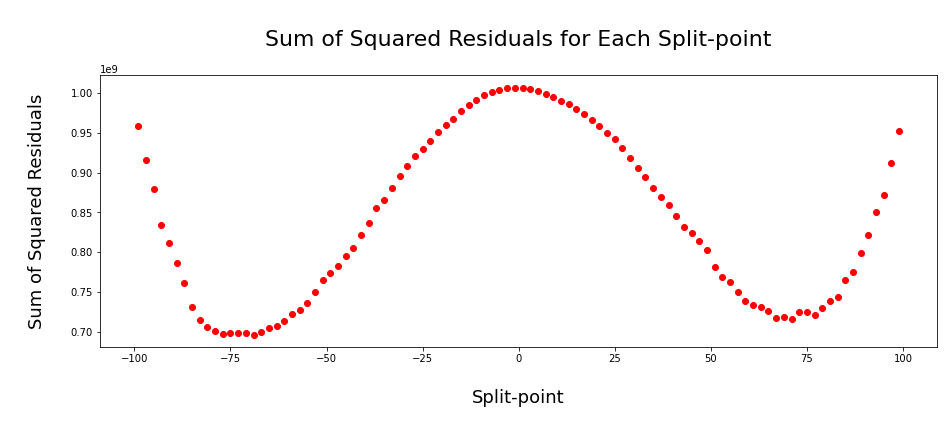

In [187]:
def calculate_SSR(pos, targets):
        left_targets, right_targets = targets[:pos+1], targets[pos+1:]
        left_mean, right_mean = np.mean(left_targets), np.mean(right_targets)
        SSR = sum((left_targets-left_mean)**2) + sum((right_targets-right_mean)**2)
        return SSR

SSRs = []
splits = []
for pos in range(len(X_train)-1):
    split = np.mean([X_train[pos], X_train[pos+1]])
    SSR = calculate_SSR(pos, y_train)
    SSRs.append(SSR)
    splits.append(split)

# Plot the SSR for each possible split
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(splits, SSRs, c='red')
ax.set_title('\nSum of Squared Residuals for Each Split-point\n', fontsize=22)
ax.set_xlabel('\nSplit-point\n', fontsize=18)
ax.set_ylabel('\nSum of Squared Residuals\n', fontsize=18)

### 1.9 - Making a Prediction from a Trained Model

The predicted output for some input value is often denoted as $\hat{y}$. This is given by the mean value of the targets in the leaf node the input has fallen in. Mathematically, the formula for determining $\hat{y}$ can be expressed as:

&nbsp;

$\begin{align}
\hat{y}=\hat{f}(x)=\sum_{m=1}^Mc_m{}I\{x\in{}R_m\}
\end{align}$

&nbsp;

where:

&nbsp; &nbsp; &nbsp; $f$ is the regression tree model written as a function

&nbsp; &nbsp; &nbsp; $x$ is an point in the feature space (input)

&nbsp; &nbsp; &nbsp; $m$ is an index of a region of the partitioned feature space

&nbsp; &nbsp; &nbsp; $M$ is the total number of regions in the partitioned feature space

&nbsp; &nbsp; &nbsp; $c_m$ is the average of the targets (output) for the training example $x$

&nbsp; &nbsp; &nbsp; $I$ is the identity function, which returns a 1 if a feature belongs to the region $R_m$ and a 0 if it does not

&nbsp; &nbsp; &nbsp; $R$ is a region of the partitioned feature space

&nbsp;

<h2 align="center">Section 2 -  Implementing a Regression Tree</h2>

### 2.1 - Introduction to Binary Trees

A binary tree is a data structure in computer science which consists of nodes connected by branches. This mirrors the structure of a decision very well, and so is used in this implementation to create a regression tree. The code below defines two classes: a `Node`, and a `Tree`. The `Node` objects are very simple, containing three attributes and two methods. The attributes are the value of the node, and a pointer to the left child node and the right child node. The methods `add_left` and `add_right` allow the pointers to the left and right child nodes to be updated respectively.

The `Tree` class defines a simple structure to connect these nodes together. Upon initialisation the tree instantiates a root node. The left and right child nodes default to `None` and are assigned later, allowing the tree to be built flexibly as required. The default string method is overwritten so that when printed the tree will return the value of each node in pre-order, that is moving depth-first across the structure.

In [188]:
class Node:

    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

    def add_left(self, value):
        self.left = Node(value)
    
    def add_right(self, value):
        self.right = Node(value)


class Tree:

    def __init__(self, root):
        self.root = Node(root)
        self.left = None
        self.right = None

    def __str__(self):
        return self.get_preorder_node(self.root, '')

    def get_preorder_node(self, start, output):
        if start is not None:
            output += f'{start.value} '
            output = self.get_preorder_node(start.left, output)
            output = self.get_preorder_node(start.right, output)
        return output


### 2.2 - Creating an Example Binary Tree

This example shows a binary tree created by manually assigning child nodes, giving a structure that is three layers deep. Printing the tree shows the values of the nodes using the pre-order approach. From this it is clear to see that the tree was searched depth-first, descending down each branch as far as possible before moving up a layer and descending down the next unexplored branched.

The first layer, *layer 0*, contains the root node with value 1. The second layer, *layer 1*, contains the left and right child nodes of the root, with values 2 and 3 respectively. These each have two child nodes which form the third layer, *layer 2*. These have values 4, 5, 6, and 7, in order of left to right. The structure is summarised in the following simple ASCII art:

&nbsp; 

            1               Layer 0
         /     \ 
       2         3          Layer 1
     /   \     /   \ 
    4     5   6     7       Layer 2

&nbsp;

In [189]:
# Layer 0
tree = Tree(1)

# Layer 1
tree.root.add_left(2)
tree.root.add_right(3)

# Layer 2
tree.root.left.add_left(4)
tree.root.left.add_right(5)
tree.root.right.add_left(6)
tree.root.right.add_right(7)

print(tree)

1 2 4 5 3 6 7 


### 2.3 - Adapting a Binary Tree for Regression Problems

The binary tree presented above has been modified for use in regression problems. In this version, each node contains the split-point used to partition the feature space, the features split, and the corresponding targets. The connected structure of nodes is maintained. The following cell inherits from the `Tree` class to construct a class specifically for creating regression trees. Separating out the general tree/node structure from the regression implementation allows this code to be reused for building classification trees.

In [190]:
class Node:

    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        self.split = None
        self.left = None
        self.right = None

    def add_left(self, features, targets):
        self.left = Node(features, targets)
    
    def add_right(self, features, targets):
        self.right = Node(features, targets)


class Tree:

    def __init__(self, features, targets):
        self.root = Node(features, targets)
        self.left = None
        self.right = None

    def __str__(self):
        return self.get_preorder_node(self.root, '')

    def get_preorder_node(self, start, output):
        if start is not None:
            output += f'{start.split} '
            output = self.get_preorder_node(start.left, output)
            output = self.get_preorder_node(start.right, output)
        return output


### 2.4 - Implementing a Regression Tree

The `Tree` class above was used to form the skeleton for the `RegressionTree` model shown below. Using the tree-like structure, model-specific methods such as `fit` and `predict` were written to allow the tree to learn from input data, and make predictions on training data respectively. The optional `min_node_size` argument can be passed upon instantiation of the model, which specifies the minimum number of observations in a node for further splits to take place. To a certain degree, this can be used to control the amount of under- and overfitting. Later in this notebook the idea of cost-complexity pruning is discussed, which covers overfitting in more depth.

In [191]:
class RegressionTree(Tree):

    ''' An implementation of a CART decision tree for regression problems.

        Attributes:
            min_node_size (int, optional):   The minimum number of observations in a node for a
                                             split to take place. Default is 20.
            predictions (list):              The most recent predictions made by the model, which
                                             can be accessed at any time. If no predictions have
                                             been made using the predict method, the default value
                                             is None.
    '''

    def __init__(self, features, targets, min_node_size=20):
        super().__init__(features, targets)
        self.min_node_size = min_node_size
        self.predictions = None
        self.fit()

    def fit(self):
        ''' Train the tree using the features and targets data passed on instantiation.

            Returns:
                None
        '''
        self.train_node(self.root)

    def train_node(self, start):
        ''' Recursively split the data at a node and create the corresponding child nodes.

            Determine the locally optimum split using the find_best_split method with the features
            and targets attributes for a given node. Split the targets and features attributes at
            the split-point and create the left and right child nodes. Recursively call the
            train_node function in a depth-wise manner to construct the entire tree structure from
            the training data.

            Args:
                start (object): The node object to start training from, this is always the root node
                                from the Tree parent class.

            Returns:
                None
        '''
        if len(start.features) > self.min_node_size:

            # Split data
            start.split = self.find_best_split(start.features, start.targets)
            data = np.stack((start.features, start.targets), axis=1)
            left_features = data[np.where(data[:,0] < start.split)][:,0]
            left_targets = data[np.where(data[:,0] < start.split)][:,1]
            right_features = data[np.where(data[:,0] >= start.split)][:,0]
            right_targets = data[np.where(data[:,0] >= start.split)][:,1]
            
            # Train left node
            start.add_left(left_features, left_targets)
            self.train_node(start.left)

            # Train right node
            start.add_right(right_features, right_targets)
            self.train_node(start.right)

        return

    def find_best_split(self, features, targets):
        ''' Find the best value in the feature space to split the data on.

            Calculate the sum of squared residuals for the child nodes using every possible split
            of the feature space. Each split is found by taking the mean of two consectutive values
            in the feature space. Return the value of the split in the feature space which gave the
            two child nodes with the lowest sum of squared residuals.

            Args:
                features (ndarray): The feature value(s) for each point.
                targets (ndarray):  The target values (outputs) for the features (inputs).

            Returns:
                best_split (float): The value in the feature space used to partition the data into
                                    the left child node and right child node.
        '''
        SSRs = []
        splits = []
        for pos in range(len(features)-1):
            split = np.mean([features[pos], features[pos+1]])
            SSR = self.calculate_SSR(pos, targets)
            SSRs.append(SSR)
            splits.append(split)

        min_SSR_index = SSRs.index(min(SSRs))
        best_split = splits[min_SSR_index]

        return best_split

    def calculate_SSR(self, pos, targets):
        ''' Calculate the sum of squared residuals for a potential split.

            Take in an integer position, pos, to divide the data in the target list. Split the
            target list in two, with left_targets containing the target values below the split, and
            the right_targets containing the values including and above the split. Calculate the
            sum of squared residuals (analogous to variance) for each of these splits and add
            together to obtain a score for how well the split performed. Lower sum of squared
            residuals represent a good split, and higher sum of squared residuals represent a poor
            split. Return the sum of squared residuals value.

            Args:
                pos (int):         The position in the targets array used to divide the data in two.
                targets (ndarray): The target values (outputs) for the features (inputs).

            Returns:
                SSR (float):        The sum of squared residuals for both child nodes after
                                    splitting about the specified position (pos).
        '''
        left_targets, right_targets = targets[:pos+1], targets[pos+1:]
        left_mean, right_mean = np.mean(left_targets), np.mean(right_targets)
        SSR = sum((left_targets-left_mean)**2) + sum((right_targets-right_mean)**2)
        return SSR

    def predict(self, data):
        ''' Predict the target values for unseen features using the model.

            Recursively search the decision tree for each input feature and append the predicted
            targets values to a predictions list. Return the predictions list.

            Args:
                data (list-like):   A collection of feature input values to be predicted using the
                                    regression tree.

            Returns:
                predictions (like): A collection of the predicted target output values predicted
                                    using the regression tree.
        '''
        self.predictions = []
        for d in data:
            self.search_nodes(d, self.root)
        return self.predictions

    
    def search_nodes(self, value, node):
        ''' Search the decision tree for a given feature value and append the target to predictions.

            Recursively search the decision tree to find the leaf node containing a value. Calculate
            the arithmetic mean of the target values for the observations in that leaf and append
            the result to the predictions list.

            Args:
                data (list-like):        A collection of feature input values to be predicted using
                                         the regression tree.

            Returns:
                predictions (like-like): A collection of the predicted target output values
                                         predicted using the regression tree.
        '''
        if node.split is not None:
            if value < node.split:
                self.search_nodes(value, node.left)
            else:
                self.search_nodes(value, node.right)
        else:
            self.predictions.append(np.mean(node.targets))
        return

### 2.5 - Tuning the Minimum Node Size

To understand how the effect of minimum node size on model performance, four different values were chosen and plotted below for 21 test data points. These minimum node size values included: 50, 20, 5, and 1. The minimum node sizes of 50 and 20 allowed a large percentage of the training data to be included in the same leaf. Selecting the minimum node size parameter in this way leads to underfitting, which is shown by the poor estimation of target values for the testing data. Conversely, choosing the minimum node size to be too small leads to overfitting, where the model lacks the ability to generalise and begins to learn the noise. This is shown below by the distribution of points around $x = 0$, which fluctuates according to the noise in the training data. These figures highlight the importance of carefully choosing the minimum node size based on the amount of data available for training.

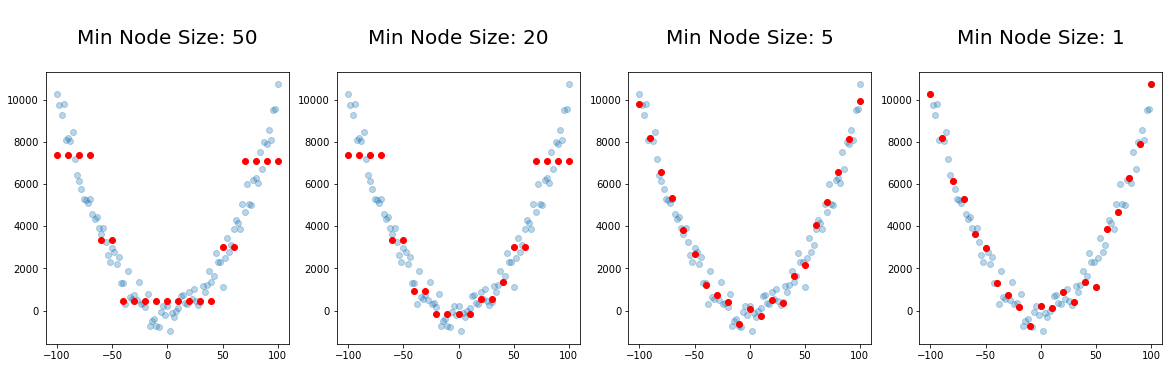

In [192]:
model_50 = RegressionTree(X_train, y_train, min_node_size=50)
model_20 = RegressionTree(X_train, y_train, min_node_size=20)
model_5 = RegressionTree(X_train, y_train, min_node_size=5)
model_1 = RegressionTree(X_train, y_train, min_node_size=1)

X_test = np.linspace(-100,100, 21)

fig, ax = plt.subplots(ncols=4, figsize=(20,5))

ax[0].set_title('\nMin Node Size: 50\n', fontsize=20)
ax[1].set_title('\nMin Node Size: 20\n', fontsize=20)
ax[2].set_title('\nMin Node Size: 5\n', fontsize=20)
ax[3].set_title('\nMin Node Size: 1\n', fontsize=20)

for i, model in enumerate([model_50, model_20, model_5, model_1]):
    ax[i].scatter(X_train, y_train, alpha=0.3)
    ax[i].scatter(X_test, model.predict(X_test), c='red')

<h2 align="center">Section 3 -Cost-Complexity Pruning</h2>

### 3.1 - Underfitting and Overfitting

Decision trees must be carefully tuned to prevent under- or overfitting. **Underfitting** occurs when the model generalises too much, and fails to capture the shape of the training data. **Overfitting** occurs when the model does not generalise enough, and captures the shape of the noise in the data.  All real-world data has noise, in this example the noise generated artificially. The curves below show for maximum leaf sizes of 50 and 20 observations, the general shape of the parabola is visible but very poorly captured. In the two graphs on the right for maximum leaf sizes of 5 and 1 observation(s), the distortions in the curves show the models have overfit the training data and learnt the noise.

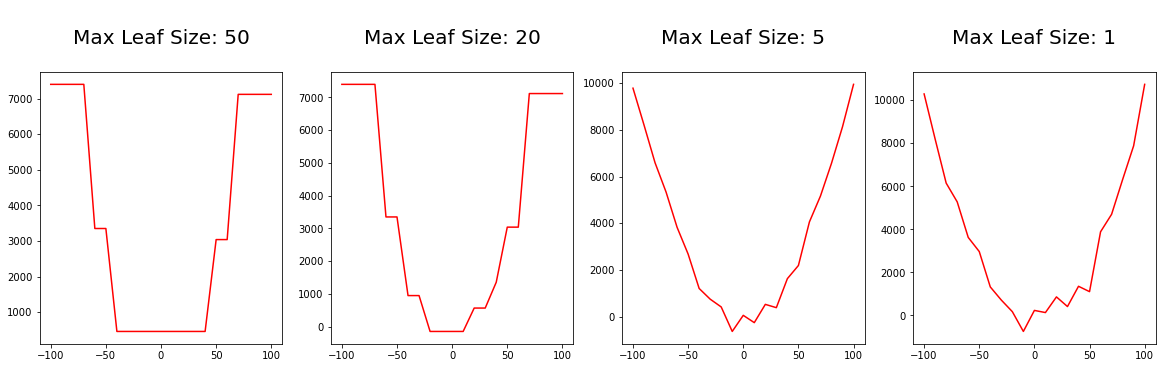

In [193]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))

ax[0].set_title('\nMax Leaf Size: 50\n', fontsize=20)
ax[1].set_title('\nMax Leaf Size: 20\n', fontsize=20)
ax[2].set_title('\nMax Leaf Size: 5\n', fontsize=20)
ax[3].set_title('\nMax Leaf Size: 1\n', fontsize=20)

for i, model in enumerate([model_50, model_20, model_5, model_1]):
    ax[i].plot(X_test, model.predict(X_test), c='red')

### 3.2 - Pruning Decision Trees

**Pruning** is the term given to reducing the size of a decision tree by recombining data from some leaf nodes. This is used as a measure to prevent overfitting training data, producing a more generalised model that in theory should perform well with testing data. There is a delicate balance when determining the correct size of a tree - a tree too large will suffer from overfitting, and a tree too small will fail to capture the structure of the data. Tree size is a parameter that should be carefully tuned.

&nbsp;

### 3.3 - Cost-Complexity Pruning

**Cost-Complexity Pruning** (or Weakest-Link Pruning) is a technique which uses SSR to determine which leaves to prune from a decision tree. The method is as follows:

1. Grow a large tree, $T$, where the nodes are split according to the minimum node size criterion (e.g. there must be a minimum of 5 observations in a node to be split further).

2. Take the sum of the SSR value for each leaf in the tree, this gives the complexity of the tree. Add a factor of $\alpha$ multiplied by the number of leaves in the tree to obtain a cost-complexity score. That is, a measure which encompasses the variation in the leaf nodes, and the size of the tree.

3. Successively collapse the tree into unique subtrees and determine the cost-complexity score for each.

4. Select the subtree with the lowest cost-complexity score.

&nbsp;

### 3.4 - The Cost-Complexity Criterion

The above method can be defined more rigorously in terms of mathematical notation. Consider a tree $T_0$ which represents the largest possible tree using the minimum node size criterion for some given training data. A subtree can be obtained by pruning $T_0$, such that $T \subset T_0$. Let the size of a tree (that is, the number of leaf nodes) be denoted by $|T|$. Terminal (leaf) nodes are indexed by $m$ which represent the region $R_m$ in the feature space. As above, $\alpha$ is a tuning parameter that can be used to control the sensitivity of the model to tree size. The cost-complexity of a subtree for a given $\alpha$ value can therefore be written as $C_{\alpha}$. The cost-complexity criterion forms an optimisation problem, where the object is to choose a subtree, $T$, such that $C_{\alpha} is minimised. This can be expressed as:

&nbsp;

$\begin{align}
\min{\Big( C_{\alpha}(T)\Big)} = \min{\Bigg( \Big[ \sum^{|T|}_{m=1} SSR(R_m) + \alpha |T| \Big] \Bigg)}
\end{align}$

&nbsp;

### 3.5 - Determining a Value for $\alpha$

The choice of $\alpha$ greatly impacts the robustness against overfitting. Large values of result is smaller trees, which if too small will fail to capture the structure of the data. Small values of $\alpha$ result in larger trees, which can lead to overfitting. Therefore it is important that $\alpha$ is chosen carefully. Generally, this is achieved by a trial-and-error approach, using 5- or 10-fold cross validation. From here, a value of $\alpha$ is chosen to minimise the cross-validated SSR. The chosen value of $\alpha$ is denoted $\hat{\alpha}$, and so the final tree is written as $T_{\hat{\alpha}}$.

&nbsp;

### 3.6 - Pruning a Regression Tree in SciKit Learn

The objects of the `DecisionTreeRegressor` class in SciKit Learn have a `ccp_alpha` attribute which is short for *cost-complexity pruning alpha*. This allows the pruning of a tree to be tuned as described above. The cell below shows the predictions made by four trees, with $\alpha$ values of: 0 (unpruned), 8000, 10000, and 50000 respectively for the parabolic training data used earlier in this notebook. Both the unpruned tree and the tree with $\alpha$ = 8000 show signs of overfitting, and produce output that has learnt the noise of the training data. The tree with $\alpha$ = 50000 generalises too much, and shows signs of heavy underfitting. The model with $\alpha$ = 10000 shows produces a model which shows good generalisation which is resistant to noise.

Text(0.5, 1.0, '\nPruned Regression\nTree Predictions\n(alpha = 50,000)\n')

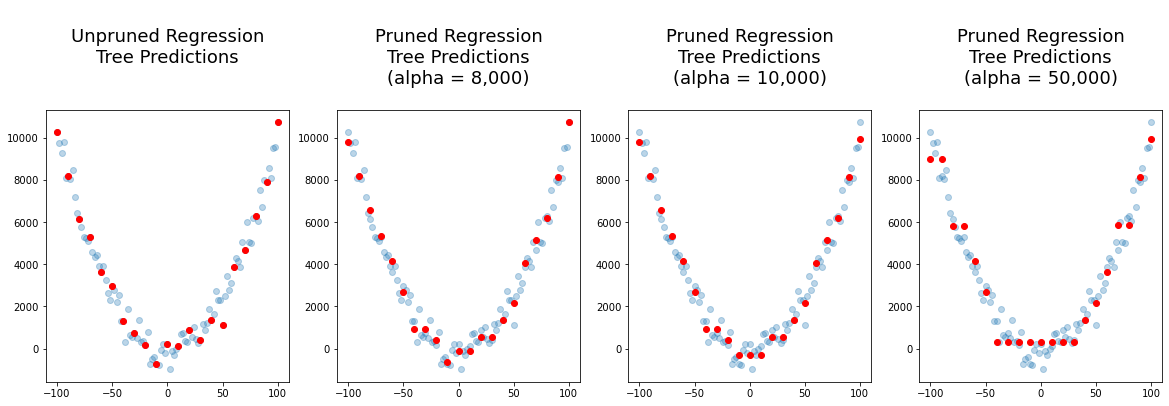

In [194]:
# Create the model
X_train = [[x] for x in X_train]
y_train = [[y] for y in y_train]

unpruned_model = DecisionTreeRegressor(random_state=0)
pruned_8_model = DecisionTreeRegressor(random_state=0, ccp_alpha=8000)
pruned_10_model = DecisionTreeRegressor(random_state=0, ccp_alpha=10000)
pruned_50_model = DecisionTreeRegressor(random_state=0, ccp_alpha=50000)

models = [unpruned_model, pruned_8_model, pruned_10_model, pruned_50_model]

# Fit the model to the training data
for model in models:
    model.fit(X_train, y_train)

# Predict the test data
X_test = [[x] for x in X_test]

# Plot results
fig, ax = plt.subplots(ncols=4, figsize=(20,5))

for i, model in enumerate(models):
    ax[i].scatter(X_train, y_train, alpha=0.3)
    ax[i].scatter(X_test, model.predict(X_test), c='red')

ax[0].set_title('\nUnpruned Regression\nTree Predictions\n\n', fontsize=18)
ax[1].set_title('\nPruned Regression\nTree Predictions\n(alpha = 8,000)\n', fontsize=18)
ax[2].set_title('\nPruned Regression\nTree Predictions\n(alpha = 10,000)\n', fontsize=18)
ax[3].set_title('\nPruned Regression\nTree Predictions\n(alpha = 50,000)\n', fontsize=18)


<h2 align="center">Section 4 - Generalising a Regression Tree to Higher Dimensions</h2>

### 4.1 - Working with Multiple Features

This notebook has explored a simple example with a single feature variable and a single target variable. Regression trees also scale well to work with multiple features. In these models each node is created using the following steps:

1. Select the first feature variable.
2. Test every possible split-point and calculate the reduction in SSR for each.
3. Record the split-point which gave the highest reduction in SSR.
4. Select the second feature variable and repeat steps 2-4, and repeat for all the features.
5. Choose the feature which brought about the greatest reduction in SSR, and split the data at the corresponding split-point.

&nbsp;

### 4.2 - Feature Importance

When working with multiple features, it is often the case that some are more significant when reducing the SSR of the predictions on some test data. This is called **feature importance** and is a useful way to rank how useful knowledge of a specific feature is when developing a model. Features with low importance may be dropped low model complexity is desired. Numerically, feature importance can be described as the sum of the reduction in variances each split (where the feature was used to split a node). These sums can then be scaled such that the sum of sums for all features is equal to 100. This gives a percentage of importance that can easily be used to rank features.

&nbsp;

<h2 align="center">Section 5 - Strengths and Limitations</h2>

### 5.1 - Strengths of Regression Trees

Regression trees have a number of disadvantages in their purest form, which are largely addressed by extensions/ensemble methods such as Xtreme Gradient Boosting and Random Forests. However, there are still a number of advantages to using simple regression trees over other models. One advantage is that the tree structure captures the interactions between features well. This is also highlighted in the interpretability of the model. which clearly shows nodes and branches to connect decisions at each stage of the prediction process. Because of this rare level of interpretability, decision trees are often used in medical settings, where an understanding of the process behind a prediction is critical. Another benefit is that regression trees are robust to non-transformed inputs, and so features do not need to be scaled or passed through logarithmic functions unlike in other models. Finally, regression trees are intrinsically contrastive, in that it is simple to ask the question "what if a data point laid here instead of there". Those sorts of questions can be answered simply by following the tree diagram down the opposite branch.

&nbsp;

### 5.2 - Limitations of Regression Trees

Regression trees produce piece-wise predictions, which is visualised in the plots in Section 3.1 above. This lack of smoothness is not something that is found in other regression models, and represents a distinct weakness in this model's approach. This couples with the next disadvantage which is the inability to handle linear relationships. Non-linear problems are generally well-solved using a regression tree, since the discretisation of space lends itself well to capturing irregular relations. However, for linear problems, models such as linear regression provide a much simpler and accurate alternative.

Regression trees, and decision trees in general, are also fairly unstable. Small changes to the training data can cause entire nodes to change, whether this be in the location of the split-point, or even the feature that the data is split about.

Overfitting is probably the main issue with regression trees, and care must taken when constructing them in order to produce a model that generalises outside of the training data. This can be controlled to some extend with cost-complexity pruning and controlling the depth of the tree, but these present more problems themselves.

&nbsp;

<h2 align="center">Section 6 - Conclusion</h2>

Regression trees are a useful model for working with non-linear relationships in data. The model scales well to handle multiple features, and can be tuned to some degree in order to prevent overfitting. Overfitting however still remains a key issue with the model, as well as the instability of the nodes with respect to the training data used to be build the model.

&nbsp;

<h2 align="center">Section 7 - Glossary</h2>

**Classification and Regression Trees** 
> A popular method for tree induction when creating classification and regression trees.

**Child Node**
> A node in a decision tree which descends from another node called a *parent node*.

**Classification Tree**
> A decision tree applied to a classification problem.

**Cost-Complexity Pruning**
> A technique which uses SSR to determine which leaves to prune from a decision tree (also known as Weakest-Link Pruning).

**Decision Tree**
> A machine learning model consisting with of a tree-like structure with nodes and branches.

**Deterministic**
> An algorithm which produces the same results from the same inputs every time.

**Feature Importance**
> The degree to which a feature in the training data has an effect on the predictions of a decision tree model.

**Greedy**
> An algorithm which make locally optimum decisions at each step.

**Node Splitting**
> The process in a decision tree of determining how to partition the training data such that the leaf nodes contain the most similar observations.

**Non-Parametric**
> A model where no assumptions are made about the form of the mapping function, and so the models are free to learn any functional form from the training data.

**Overfitting**
> When a model does not generalise enough, and captures the shape of the noise in the data. 

**Parent Node**
> A node in a decision tree from which other nodes descend, the descending nodes are called *child nodes*.
**Pruning**
> Reducing the size of a decision tree by recombining data from some leaf nodes.

**Regression Tree**
> A decision tree applied to a regression problem.

**Root Node**
> The first node of a decision tree, from which all other nodes descend - generally depicted at the top of a tree diagram.

**Terminal Node**
> See *Leaf Node*.

**Tree Induction**
> The method for producing a tree from training data. 

**Underfitting**
> When a model generalises too much, and fails to capture the shape of the training data.

&nbsp;

<h2 align="center">Section 8 - Further Reading</h2>

[1] Non-Parameteric Machine Learning Models - [Machine Learning Mastery](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/#:~:text=Algorithms%20that%20do%20not%20make,form%20from%20the%20training%20data.)

[2] The Elements of Statistical Learning - [Hastie.su](https://hastie.su.domains/Papers/ESLII.pdf)

[3] Classification and Regression Trees, CART - [Interpertable Machine Learning](https://christophm.github.io/interpretable-ml-book/tree.html#fnref18)